Compare output from dask streaming analysis to results from Fluctana.

We calculate results from RMCs examples/nersc/check_correlation.py for Channels L1102 and L0906 to
results from the streaming analysis package.


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib as mpl
mpl.rcParams["xtick.labelsize"] = "large"
mpl.rcParams["ytick.labelsize"] = "large"

import matplotlib.pyplot as plt
from scipy.signal import stft, spectrogram, detrend

import timeit

In [2]:
import sys
sys.path.append("/global/homes/r/rkube/repos/delta")
from analysis.channels import channel, channel_pair

In [3]:
win = np.hanning(512)
win_factor = np.mean(win**2) 
print("win_Factor = ", win_factor)

win_Factor =  0.374267578125


In [4]:
# Run the fluctana code from RMCs examples/nersc/check_correlation.py

In [18]:
def test_rmc():
    #import sys, os
    #sys.path.append(os.pardir)
    sys.path.append("/global/homes/r/rkube/repos/fluctana_rmc")
    from fluctana import FluctAna, KstarEcei

    # HOW TO RUN
    # ./python3 check_correlation.py 10186 [15.9,16] ECEI_L1303 ECEI_L1403

    shot = 18431 
    trange = [-0.1, -0.08]
    clist = [['ECEI_L0906'], ['ECEI_L1102']]

    # call fluctana
    A = FluctAna()

    # add data
    A.add_data(KstarEcei(shot=shot, clist=clist[0], data_path='/global/cscratch1/sd/rkube/KSTAR/kstar_streaming/'), trange=trange, norm=1)
    A.add_data(KstarEcei(shot=shot, clist=clist[1], data_path='/global/cscratch1/sd/rkube/KSTAR/kstar_streaming/'), trange=trange, norm=1)

    # list data
    A.list_data()

    # do fft; full = 1 
    A.fftbins(nfft=512,window='hann',overlap=0.5,detrend=0,full=1)

    # calculate correlation using data sets done and dtwo. results are saved in A.Dlist[dtwo].val
    A.correlation(done=0, dtwo=1)

    # plot the results; dnum = data set number, cnl = channel number list to plot
    A.mplot(dnum=1,cnl=range(len(A.Dlist[1].clist)),type='val')
    
    return(A)



Rading init: 
Data is normalized by trange average ECEI
LOW signal level channel ECEI_L0906, ref = 100%, siglevel = -0.0001 V
Rading init: 
Data is normalized by trange average ECEI
LOW signal level channel ECEI_L1102, ref = 100%, siglevel = -0.0003 V
---- DATA SET # 0 for [-0.100000, -0.080000] s ----
[000:ECEI_L0906]
---- DATA SET # 1 for [-0.100000, -0.080000] s ----
[000:ECEI_L1102]
dnum 0 fftbins 37 with hann size 512 overlap 0.5 detrend 0 full 1
dnum 1 fftbins 37 with hann size 512 overlap 0.5 detrend 0 full 1


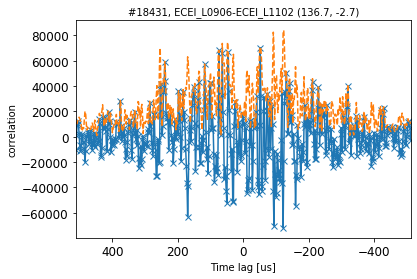

Fluctana takes 0.5140s


In [19]:
tic = timeit.default_timer()
A = test_rmc()
toc = timeit.default_timer()

print("Fluctana takes {0:6.4f}s".format(toc - tic))

In [20]:
def fftbins(x, dt, nfft, window, overlap, do_detrend, full):
    # IN : 1 x tnum data
    # OUT : bins x faxis fftdata
    tnum = len(x)
    
    bins = int(np.fix((int(tnum/nfft) - overlap)/(1.0 - overlap)))
    win = np.hanning(nfft)
    #bins, win = fft_window(tnum, nfft, window, overlap)
    win_factor = np.mean(win**2)  # window factors
    print("***fftbins: win_factor = {0:f}".format(win_factor))

    # make an x-axis #
    ax = np.fft.fftfreq(nfft, d=dt) # full 0~fN -fN~-f1
    if np.mod(nfft, 2) == 0:  # even nfft
        ax = np.hstack([ax[0:int(nfft/2)], -(ax[int(nfft/2)]), ax[int(nfft/2):nfft]])
    if full == 1: # full shift to -fN ~ 0 ~ fN
        ax = np.fft.fftshift(ax)
    else: # half 0~fN
        ax = ax[0:int(nfft/2+1)]

    # make fftdata
    if full == 1: # full shift to -fN ~ 0 ~ fN
        if np.mod(nfft, 2) == 0:  # even nfft
            fftdata = np.zeros((bins, nfft+1), dtype=np.complex_)
        else:  # odd nfft
            fftdata = np.zeros((bins, nfft), dtype=np.complex_)
    else: # half 0 ~ fN
        fftdata = np.zeros((bins, int(nfft/2+1)), dtype=np.complex_)

    for b in range(bins):
        idx1 = int(b*np.fix(nfft*(1 - overlap)))
        idx2 = idx1 + nfft
        #print("***bin {0:d}, idx1 = {1:d}, idx2 = {2:d}".format(b, idx1, idx2))

        sx = x[idx1:idx2]

        if do_detrend == 1:
            sx = detrend(sx, type='linear')
        sx = detrend(sx, type='constant')  # subtract mean
        sx = sx * win  # apply window function

        # get fft
        SX = np.fft.fft(sx, n=nfft)/nfft  # divide by the length
        if np.mod(nfft, 2) == 0:  # even nfft
            SX = np.hstack([SX[0:int(nfft/2)], np.conj(SX[int(nfft/2)]), SX[int(nfft/2):nfft]])
        if full == 1: # shift to -fN ~ 0 ~ fN
            SX = np.fft.fftshift(SX)
        else: # half 0 ~ fN
            SX = SX[0:int(nfft/2+1)]

        fftdata[b,:] = SX

    return ax, fftdata, win_factor

fluctana.FluctAna

***fftbins: win_factor = 0.374268
(37, 513)
***fftbins: win_factor = 0.374268


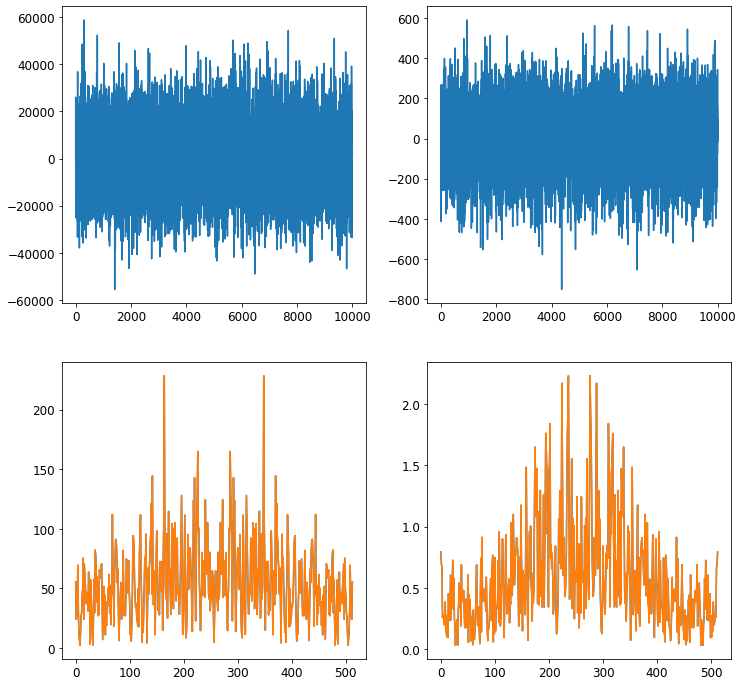

In [21]:
L1102_fa = np.squeeze(A.Dlist[0].data)
L1102_ax, L1102_ft, win_factor = fftbins(L1102_fa, dt=2e-6, nfft=512, window="hann", overlap=0.5, do_detrend=0, full=1)

print(L1102_ft.shape)

L0906_fa = np.squeeze(A.Dlist[1].data)
L0906ax, L0906_ft, win_factor = fftbins(L0906_fa, dt=2e-6, nfft=512, window="hann", overlap=0.5, do_detrend=0, full=1)

plt.figure(figsize=(12,12))
plt.subplot(221)
plt.plot(L1102_fa)
plt.subplot(222)
plt.plot(L0906_fa)

plt.subplot(223)
plt.plot(np.abs(L1102_ft.mean(axis=0)))
plt.plot(np.abs(A.Dlist[0].spdata[0].mean(axis=0)))
plt.subplot(224)
plt.plot(np.abs(L0906_ft.mean(axis=0)))
plt.plot(np.abs(A.Dlist[1].spdata[0].mean(axis=0)))

In [22]:
c1 = channel('L', 11, 2)
c2 = channel('L', 9, 6)

print("Channel 1: ", c1, ", idx = ", c1.idx())
print("Channel 2: ", c2, ", idx = ", c2.idx())

with np.load("../test_data/cross_correlation_s00001.npz", allow_pickle=True) as df:
    # Load output of dask
    res_dask = df["data"]
    res_dask = np.concatenate(res_dask, axis=0)
    print("res_dask.shape = ", res_dask.shape)
    
with np.load("../test_data/io_array_s0001.npz") as df:
    # Load raw data, as read by datareader 
    io_array = df["io_array"]
    print("io_array.shape = ", io_array.shape)

with np.load("../test_data/io_array_tr_s0001.npz") as df:
    # Load transformed data, as generated by datareader
    io_array_tr = df["io_array"]
    print("io_array_tr.shape = ", io_array_tr.shape)

with np.load("../test_data/offset_lvl.npz") as df:
    # Load offset data, as calculated by datareader
    offset_lvl = df["offset_lvl"]
    
with np.load("../test_data/fft_data_s0001.npz") as df:
    # Load FFT data, as calculated by processor.
    fft_data = df["fft_data"]
    print("fft_data.shape = ", fft_data.shape)
    
_tmp = detrend(io_array, axis=1, type="constant")
res = stft(_tmp, fs=1./2e-6, nperseg=512, window="hann",
                 detrend="constant", noverlap=256, padded=False,
                 return_onesided=False, boundary=None)
io_array_ft = np.fft.fftshift(res[2], axes=1)

fft_data = np.fft.fftshift(fft_data, axes=1)

print("io_array_ft.shape = ", io_array_ft.shape)
print("Channel idx for ", c1, ": {0:d}".format(c1.idx()), " for ", c1, ", {0:d}".format(c2.idx()))

Channel 1:  L1102 , idx =  81
Channel 2:  L0906 , idx =  69
res_dask.shape =  (18528, 512)
io_array.shape =  (192, 10000)
io_array_tr.shape =  (192, 10000)
fft_data.shape =  (192, 512, 38)
io_array_ft.shape =  (192, 512, 38)
Channel idx for  L1102 : 81  for  L1102 , 69


In [23]:
print(res_dask[0].shape)
print(res_dask[1].shape)

(512,)
(512,)


In [24]:
with np.load("../tests_div/test.npz", allow_pickle=True) as df:
    channel_list = df["flat_ll"]

In [25]:
channel_list[0] == channel_pair(channel('L', 1, 1), channel('L', 1, 1))

True

In [26]:
np.argwhere(channel_list == channel_pair(c1, c2))[0][0]

10914

In [27]:
print(channel_list[10914])

(L0906, L1102)


(L0101, L0101)


Text(0.5, 1.0, 'Channel L0906')

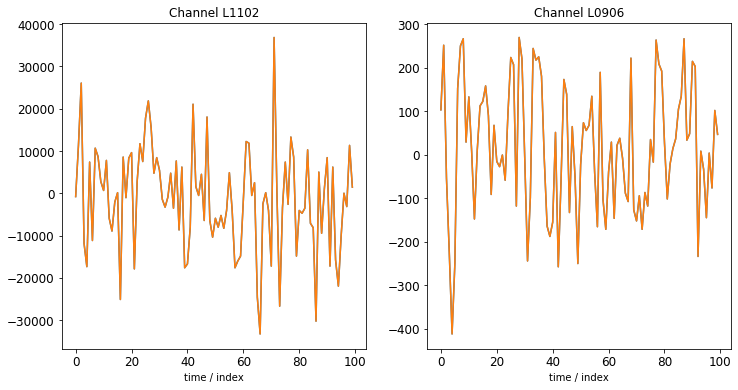

In [30]:
plt.figure(figsize=(12, 6))
plt.subplot(121)

plt.plot(io_array_tr[c2.idx(),:100])
plt.plot(L1102_fa[:100])
plt.xlabel("time / index")
plt.title("Channel " + str(c1))

plt.subplot(122)
plt.plot(io_array_tr[c1.idx(),:100])
plt.plot(L0906_fa[:100])
plt.xlabel("time / index")
plt.title("Channel " + str(c2))

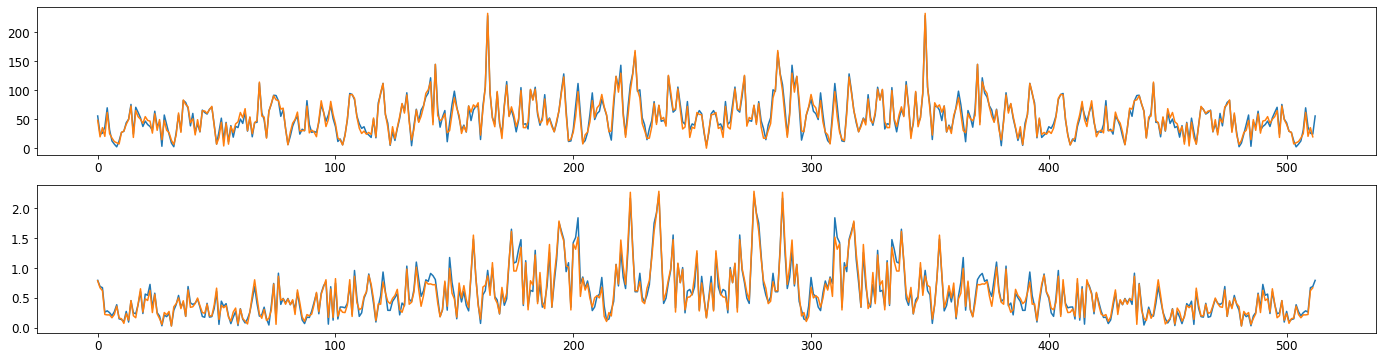

In [32]:
plt.figure(figsize=(24, 6))

plt.subplot(211)
plt.plot(np.abs(L1102_ft.mean(axis=0)))
plt.plot(np.abs(fft_data[c2.idx(), :, :].mean(axis=1)) * 0.5)

plt.subplot(212)
plt.plot(np.abs(L0906_ft.mean(axis=0)))
plt.plot(np.abs(fft_data[c1.idx(), :, :].mean(axis=1)) * 0.5)

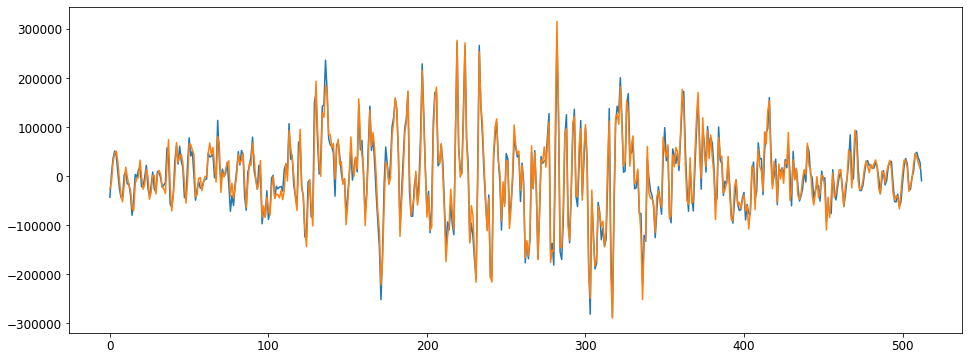

In [33]:
plt.figure(figsize=(16, 6))
plt.plot(A.Dlist[1].val[0] * 4)
plt.plot(res_dask[10914,:])

In [30]:
mycorr1_1 = corr_here_v1(io_array_ft[c1.idx(), :, :], io_array_ft[c2.idx(), :, :], win_factor, 512)
mycorr1_2 = corr_here_v1(fft_data[c1.idx(), :, :], fft_data[c2.idx(), :, :], win_factor, 512)
mycorr1_3 = corr_here_v1(A.Dlist[0].spdata[0,:,:].T, A.Dlist[1].spdata[0,:,:].T, win_factor, 513)

/global/homes/r/rkube/.conda/envs/xgc-adios2-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


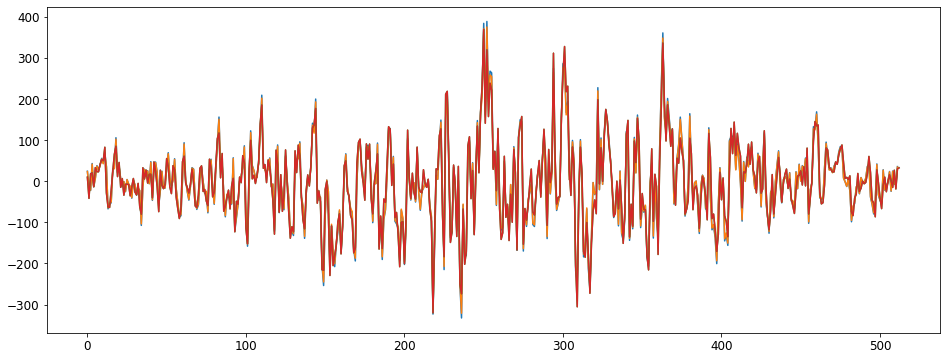

In [37]:
plt.figure(figsize=(16, 6))
plt.plot(mycorr1_1.mean(axis=1) * 512 * 512 * 32)
plt.plot(mycorr1_2.mean(axis=1))
plt.plot(mycorr1_3.mean(axis=1) * 4)
plt.plot(A.Dlist[1].val[0] * 4)

In [39]:
mycorr2_1 = corr_here_v2(io_array_ft[c1.idx(), :, :], io_array_ft[c2.idx(), :, :], win_factor, 512)
mycorr2_2 = corr_here_v2(fft_data[c1.idx(), :, :], fft_data[c2.idx(), :, :], win_factor, 512)
mycorr2_3 = corr_here_v2(A.Dlist[0].spdata[0,:,:].T, A.Dlist[1].spdata[0,:,:].T, win_factor, 513)

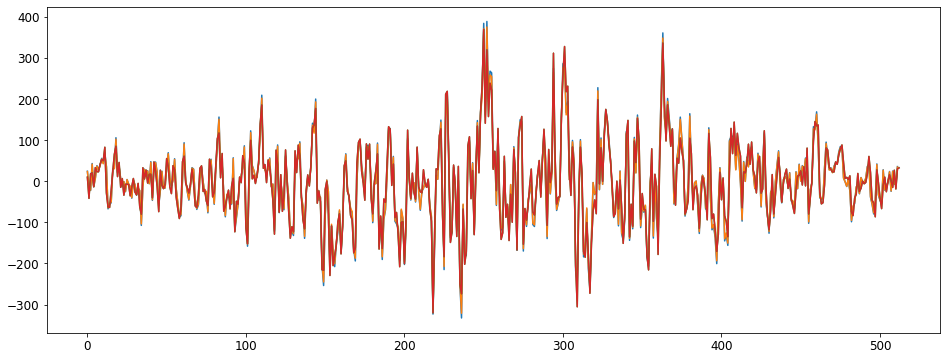

In [44]:
plt.figure(figsize=(16, 6))
plt.plot(mycorr2_1 * 512 * 512 * 32)
plt.plot(mycorr2_2)
plt.plot(mycorr2_3 * 4)
plt.plot(A.Dlist[1].val[0] * 4)

In [45]:
mycorr3_1 = corr_here_v3(io_array_ft[c1.idx(), :, :].T, io_array_ft[c2.idx(), :, :].T, win_factor, 512)
mycorr3_2 = corr_here_v3(fft_data[c1.idx(), :, :].T, fft_data[c2.idx(), :, :].T, win_factor, 512)
mycorr3_3 = corr_here_v3(A.Dlist[0].spdata[0,:,:], A.Dlist[1].spdata[0,:,:], win_factor, 513)

(38, 512) (38, 512)
(38, 512) (38, 512)
(37, 513) (37, 513)


/global/homes/r/rkube/.conda/envs/xgc-adios2-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:29: ComplexWarning: Casting complex values to real discards the imaginary part


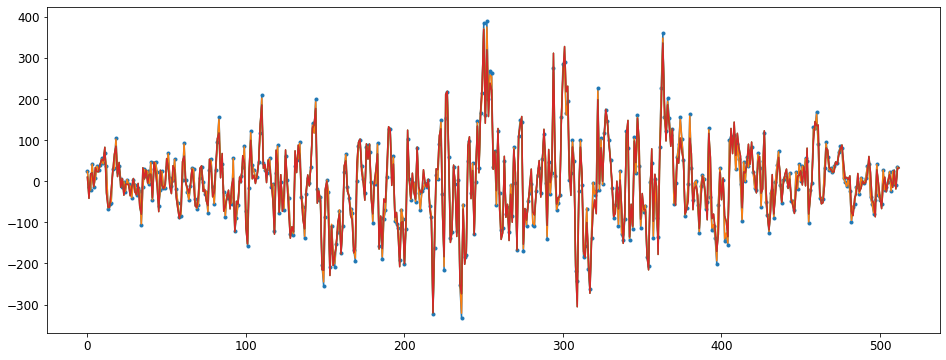

In [48]:
plt.figure(figsize=(16, 6))

plt.plot(mycorr3_1.mean(axis=0) * 512 * 512 * 32, '.-')
plt.plot(mycorr3_2.mean(axis=0))
plt.plot(mycorr3_3.mean(axis=0) * 4)

plt.plot(A.Dlist[1].val[0] * 4)

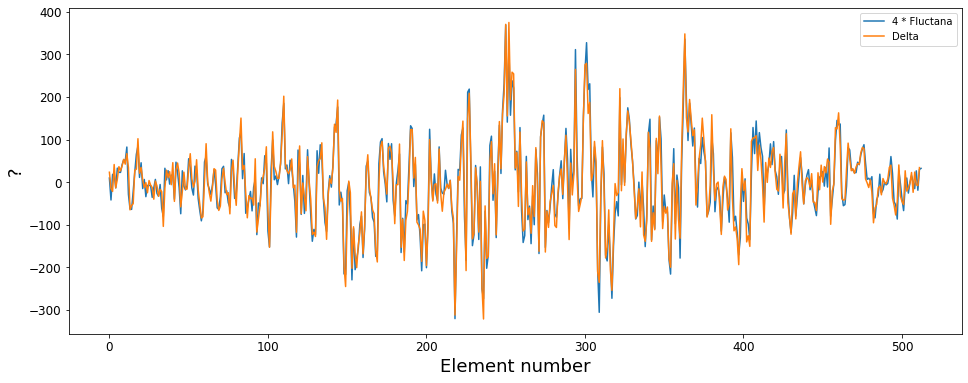

In [27]:
plt.figure(figsize=(16, 6))
plt.plot(A.Dlist[1].val[0] * 4, label="4 * Fluctana")
plt.plot(ralphs_task[1,:], label="Delta")
plt.legend(loc="upper right")

plt.xlabel("Element number", fontsize=18)
plt.ylabel("?", fontsize=18)
plt.title("")
#plt.savefig("fluctana_vs_delta.svg")